# Introduction
The author follows the CRISP-DM methodology.
![CRISP-DM](Data/crisp.png)

# Business Understanding

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Data Understanding

application_{train|test}.csv

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

bureau.csv

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

POS_CASH_balance.csv

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

credit_card_balance.csv

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

previous_application.csv

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

HomeCredit_columns_description.csv

- This file contains descriptions for the columns in the various data files.

![CRISP-DM](Data/home_credit.png)

Start Spark

In [1]:
import pandas as pd
import findspark 
import os
from pyspark import SparkContext 
from pyspark.sql import SparkSession
findspark.init() 
spark = SparkSession\
    .builder\
    .appName("HomeCreditApp")\
    .config("spark.driver.memory", "4G")\
    .config("spark.executor.memory", "2G")\
    .getOrCreate()

# Data Preparation

Functions

In [2]:
from pyspark.sql.functions import lit
def load_file(file):
    sparkData = spark\
            .read\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .option("delimiter", ",")\
            .csv("Data/" + file + ".csv")\
            .cache()
    return sparkData

def aggregate(sparkData, column, fce):
    if fce == 'count':
        sparkData = sparkData.select(column)
        sparkData = sparkData.withColumn(column + '_count', lit(None))
    returnData = getattr(sparkData.groupBy(column), fce)()
    idList = ['SK_ID_BUREAU', 'SK_ID_PREV', 'SK_ID_CURR']
    for idVal in idList:
        newColumn = fce + '(' + idVal + ')'
        if newColumn in returnData.columns:
            returnData = returnData.drop(newColumn)
    return returnData

def left_join(sparkData1, sparkData2, column, prefix):
    for col in sparkData2.columns:
          sparkData2 = sparkData2.withColumnRenamed(col, prefix + col)
    columnTemp = prefix + column
    sparkData = sparkData1.join(sparkData2, sparkData1[column] == sparkData2[columnTemp], how='left')
    sparkData = sparkData.drop(columnTemp)
    return sparkData

Load tables

In [3]:
dfAppTrain = load_file('application_train')
dfAppTest = load_file('application_test')
dfBureau = load_file('bureau')
dfBureauBal = load_file('bureau_balance')
dfPOSCashBal = load_file('POS_CASH_balance')
dfPrevApp = load_file('previous_application')
dfInstPay = load_file('installments_payments')
dfCreditCBalance = load_file('credit_card_balance')

Aggregation of leaves

In [4]:
dfBureauBalMin = aggregate(dfBureauBal, 'SK_ID_BUREAU', 'min')
dfBureauBalMax = aggregate(dfBureauBal, 'SK_ID_BUREAU', 'max')
dfBureauBalAvg = aggregate(dfBureauBal, 'SK_ID_BUREAU', 'avg')
dfBureauBalCount = aggregate(dfBureauBal, 'SK_ID_BUREAU', 'count')
prevDfPOSCashBalMin = aggregate(dfPOSCashBal, 'SK_ID_PREV', 'min')
prevDfPOSCashBalMax = aggregate(dfPOSCashBal, 'SK_ID_PREV', 'max')
prevDfPOSCashBalAvg = aggregate(dfPOSCashBal, 'SK_ID_PREV', 'avg')
prevDfPOSCashBalCount = aggregate(dfPOSCashBal, 'SK_ID_PREV', 'count')
prevDfInstPayMin = aggregate(dfInstPay, 'SK_ID_PREV', 'min')
prevDfInstPayMax = aggregate(dfInstPay, 'SK_ID_PREV', 'max')
prevDfInstPayAvg = aggregate(dfInstPay, 'SK_ID_PREV', 'avg')
prevDfInstPayCount = aggregate(dfInstPay, 'SK_ID_PREV', 'count')
prevDfCreditCBalanceMin = aggregate(dfCreditCBalance, 'SK_ID_PREV', 'min')
prevDfCreditCBalanceMax = aggregate(dfCreditCBalance, 'SK_ID_PREV', 'max')
prevDfCreditCBalanceAvg = aggregate(dfCreditCBalance, 'SK_ID_PREV', 'avg')
prevDfCreditCBalanceCount = aggregate(dfCreditCBalance, 'SK_ID_PREV', 'count')

Joins in second layer

In [5]:
dfBureau = left_join(dfBureau, dfBureauBalMin, 'SK_ID_BUREAU', 'bureau_balance_')
dfBureau = left_join(dfBureau, dfBureauBalMax, 'SK_ID_BUREAU', 'bureau_balance_')
dfBureau = left_join(dfBureau, dfBureauBalAvg, 'SK_ID_BUREAU', 'bureau_balance_')
dfBureau = left_join(dfBureau, dfBureauBalCount, 'SK_ID_BUREAU', 'bureau_balance_')
dfPrevApp = left_join(dfPrevApp, prevDfPOSCashBalMin, 'SK_ID_PREV', 'pos_')
dfPrevApp = left_join(dfPrevApp, prevDfPOSCashBalMax, 'SK_ID_PREV', 'pos_')
dfPrevApp = left_join(dfPrevApp, prevDfPOSCashBalAvg, 'SK_ID_PREV', 'pos_')
dfPrevApp = left_join(dfPrevApp, prevDfPOSCashBalCount, 'SK_ID_PREV', 'pos_')
dfPrevApp = left_join(dfPrevApp, prevDfInstPayMin, 'SK_ID_PREV', 'inst_pay_')
dfPrevApp = left_join(dfPrevApp, prevDfInstPayMax, 'SK_ID_PREV', 'inst_pay_')
dfPrevApp = left_join(dfPrevApp, prevDfInstPayAvg, 'SK_ID_PREV', 'inst_pay_')
dfPrevApp = left_join(dfPrevApp, prevDfInstPayCount, 'SK_ID_PREV', 'inst_pay_')
dfPrevApp = left_join(dfPrevApp, prevDfCreditCBalanceMin, 'SK_ID_PREV', 'credit_balance_')
dfPrevApp = left_join(dfPrevApp, prevDfCreditCBalanceMax, 'SK_ID_PREV', 'credit_balance_')
dfPrevApp = left_join(dfPrevApp, prevDfCreditCBalanceAvg, 'SK_ID_PREV', 'credit_balance_')
dfPrevApp = left_join(dfPrevApp, prevDfCreditCBalanceCount, 'SK_ID_PREV', 'credit_balance_')

Aggregation of nodes

In [6]:
dfBureauMin = aggregate(dfBureau, 'SK_ID_CURR', 'min')
dfBureauMax = aggregate(dfBureau, 'SK_ID_CURR', 'max')
dfBureauAvg = aggregate(dfBureau, 'SK_ID_CURR', 'avg')
dfBureauCount = aggregate(dfBureau, 'SK_ID_CURR', 'count')
dfPrevAppMin = aggregate(dfPrevApp, 'SK_ID_CURR', 'min')
dfPrevAppMax = aggregate(dfPrevApp, 'SK_ID_CURR', 'max')
dfPrevAppAvg = aggregate(dfPrevApp, 'SK_ID_CURR', 'avg')
dfPrevAppCount = aggregate(dfPrevApp, 'SK_ID_CURR', 'count')
dfPOSCashBalMin = aggregate(dfPOSCashBal, 'SK_ID_CURR', 'min')
dfPOSCashBalMax = aggregate(dfPOSCashBal, 'SK_ID_CURR', 'max')
dfPOSCashBalAvg = aggregate(dfPOSCashBal, 'SK_ID_CURR', 'avg')
dfPOSCashBalCount = aggregate(dfPOSCashBal, 'SK_ID_CURR', 'count')
dfInstPayMin = aggregate(dfInstPay, 'SK_ID_CURR', 'min')
dfInstPayMax = aggregate(dfInstPay, 'SK_ID_CURR', 'max')
dfInstPayAvg = aggregate(dfInstPay, 'SK_ID_CURR', 'avg')
dfInstPayCount = aggregate(dfInstPay, 'SK_ID_CURR', 'count')
dfCreditCBalanceMin = aggregate(dfCreditCBalance, 'SK_ID_CURR', 'min')
dfCreditCBalanceMax = aggregate(dfCreditCBalance, 'SK_ID_CURR', 'max')
dfCreditCBalanceAvg = aggregate(dfCreditCBalance, 'SK_ID_CURR', 'avg')
dfCreditCBalanceCount = aggregate(dfCreditCBalance, 'SK_ID_CURR', 'count')

Final join to one table

In [7]:
def join_to_main(dfMain):
    dfMain = left_join(dfMain, dfBureauMin, 'SK_ID_CURR', 'bureau_')
    dfMain = left_join(dfMain, dfBureauMax, 'SK_ID_CURR', 'bureau_')
    dfMain = left_join(dfMain, dfBureauAvg, 'SK_ID_CURR', 'bureau_')
    dfMain = left_join(dfMain, dfBureauCount, 'SK_ID_CURR', 'bureau_')
    dfMain = left_join(dfMain, dfPrevAppMin, 'SK_ID_CURR', 'prev_app_')
    dfMain = left_join(dfMain, dfPrevAppMax, 'SK_ID_CURR', 'prev_app_')
    dfMain = left_join(dfMain, dfPrevAppAvg, 'SK_ID_CURR', 'prev_app_')
    dfMain = left_join(dfMain, dfPrevAppCount, 'SK_ID_CURR', 'prev_app_')
    dfMain = left_join(dfMain, dfPOSCashBalMin, 'SK_ID_CURR', 'pos_')
    dfMain = left_join(dfMain, dfPOSCashBalMax, 'SK_ID_CURR', 'pos_')
    dfMain = left_join(dfMain, dfPOSCashBalAvg, 'SK_ID_CURR', 'pos_')
    dfMain = left_join(dfMain, dfPOSCashBalCount, 'SK_ID_CURR', 'pos_')
    dfMain = left_join(dfMain, dfInstPayMin, 'SK_ID_CURR', 'inst_pay_')
    dfMain = left_join(dfMain, dfInstPayMax, 'SK_ID_CURR', 'inst_pay_')
    dfMain = left_join(dfMain, dfInstPayAvg, 'SK_ID_CURR', 'inst_pay_')
    dfMain = left_join(dfMain, dfInstPayCount, 'SK_ID_CURR', 'inst_pay_')
    dfMain = left_join(dfMain, dfCreditCBalanceMin, 'SK_ID_CURR', 'credit_balance_')
    dfMain = left_join(dfMain, dfCreditCBalanceMax, 'SK_ID_CURR', 'credit_balance_')
    dfMain = left_join(dfMain, dfCreditCBalanceAvg, 'SK_ID_CURR', 'credit_balance_')
    dfMain = left_join(dfMain, dfCreditCBalanceCount, 'SK_ID_CURR', 'credit_balance_')
    return dfMain

In [8]:
sparkApplicationData = join_to_main(dfAppTrain)
sparkApplicationDataTest = join_to_main(dfAppTest)

In [9]:
dfAppTrain.unpersist()
dfAppTest.unpersist()
dfBureauMin.unpersist()
dfBureauMax.unpersist()
dfPrevAppMin.unpersist()
dfPrevAppMax.unpersist()
dfPOSCashBalMin.unpersist()
dfPOSCashBalMax.unpersist()
dfInstPayMin.unpersist()
dfInstPayMax.unpersist()
dfCreditCBalanceMin.unpersist()
dfCreditCBalanceMax.unpersist()
dfAppTrain.unpersist()
dfAppTest.unpersist()
dfBureau.unpersist()
dfBureauBal.unpersist()
dfPOSCashBal.unpersist()
dfPrevApp.unpersist()
dfInstPay.unpersist()
dfCreditCBalance.unpersist()
print('OK')

OK


Columns

In [10]:
sparkApplicationData\
  .printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [11]:
def displayPandas(sparkData):
    display(
    sparkData
      .limit(5)
      .toPandas()
    )

First 5 rows.

In [12]:
displayPandas(sparkApplicationData)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,credit_balance_avg(AMT_RECIVABLE),credit_balance_avg(AMT_TOTAL_RECEIVABLE),credit_balance_avg(CNT_DRAWINGS_ATM_CURRENT),credit_balance_avg(CNT_DRAWINGS_CURRENT),credit_balance_avg(CNT_DRAWINGS_OTHER_CURRENT),credit_balance_avg(CNT_DRAWINGS_POS_CURRENT),credit_balance_avg(CNT_INSTALMENT_MATURE_CUM),credit_balance_avg(SK_DPD),credit_balance_avg(SK_DPD_DEF),credit_balance_count
0,100274,0,Cash loans,M,Y,Y,0,308250.0,1305000.0,38281.5,...,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,25.0
1,100800,0,Cash loans,F,N,Y,0,126000.0,698517.0,23215.5,...,1148.956364,1148.956364,0.5,0.090909,0.0,0.0,0.0,0.0,0.0,11.0
2,100884,0,Cash loans,F,N,Y,0,157500.0,327024.0,21420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100986,0,Cash loans,M,Y,Y,0,180000.0,640080.0,29970.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101094,0,Cash loans,F,N,Y,0,112500.0,819432.0,23958.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of rows

In [13]:
print(sparkApplicationData.count())

307511


The same types and columns.

In [14]:
trainTypes = sparkApplicationData.dtypes
testTypes = sparkApplicationDataTest.dtypes
for (trainCol, trainColType) in trainTypes:
    found = 0
    for (testCol, testColType) in testTypes:
        if testCol == trainCol:
            found = 1
            if testColType != trainColType:
                print('Change type for: ' + col)
                sparkApplicationDataTest = sparkApplicationDataTest.withColumn(trainCol, sparkApplicationDataTest[trainCol].cast(trainColType))
    if found == 0 and trainCol != 'TARGET':
        print('New column: ' + col)
        sparkApplicationDataTest = sparkApplicationDataTest.withColumn(trainCol, lit(None).cast(trainColType))

# Modeling

Data is transfered to H20

In [15]:
import h2o
from pysparkling import *

h2o.init()
h2oContext = H2OContext.getOrCreate()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 15 hours 11 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,sparkling-water-lukas.sykora_local-1586962864883
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.503 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://192.168.31.21:54323 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,sparkling-water-lukas.sykora_local-1587104026684
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.1-1-2.4
 * H2O name: sparkling-water-lukas.sykora_local-1587104026684
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,192.168.31.21,54323)
  ------------------------

  Open H2O Flow in browser: http://192.168.31.21:54325 (CMD + click in Mac OSX)

    


In [16]:
df_train = h2oContext.asH2OFrame(sparkApplicationData)
sparkApplicationData.unpersist()
print('OK')

OK


In [17]:
df_test = h2oContext.asH2OFrame(sparkApplicationDataTest)
sparkApplicationDataTest.unpersist()
print('OK')

OK


In [18]:
df_train.describe()

Rows:307511
Cols:613




SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE NAME_EDUCATION_TYPE NAME_FAMILY_STATUS NAME_HOUSING_TYPE REGION_POPULATION_RELATIVE DAYS_BIRTH DAYS_EMPLOYED DAYS_REGISTRATION DAYS_ID_PUBLISH OWN_CAR_AGE FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE FLAG_PHONE FLAG_EMAIL OCCUPATION_TYPE CNT_FAM_MEMBERS REGION_RATING_CLIENT REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START HOUR_APPR_PROCESS_START REG_REGION_NOT_LIVE_REGION REG_REGION_NOT_WORK_REGION LIVE_REGION_NOT_WORK_REGION REG_CITY_NOT_LIVE_CITY REG_CITY_NOT_WORK_CITY LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 APARTMENTS_AVG BASEMENTAREA_AVG YEARS_BEGINEXPLUATATION_AVG YEARS_BUILD_AVG COMMONAREA_AVG ELEVATORS_AVG ENTRANCES_AVG FLOORSMAX_AVG FLOORSMIN_AVG LANDAREA_AVG LIVINGAPARTMENTS_AVG LIVINGAREA_AVG NONLIVINGAPARTMENTS_AVG NONLIVINGAREA_AVG APARTMENTS_MODE BASEMENTAREA_MODE YEARS_BEGINEXPLUATATION_MODE YEARS_BUILD_MODE COMMONAREA_MODE ELEVATORS_MODE ENTRANCES_MODE FLOORSMAX_MODE FLOORSMIN_MODE LANDAREA_MODE LIVINGAPARTMENTS_MODE LIVINGAREA_MODE NONLIVINGAPARTMENTS_MODE NONLIVINGAREA_MODE APARTMENTS_MEDI BASEMENTAREA_MEDI YEARS_BEGINEXPLUATATION_MEDI YEARS_BUILD_MEDI COMMONAREA_MEDI ELEVATORS_MEDI ENTRANCES_MEDI FLOORSMAX_MEDI FLOORSMIN_MEDI LANDAREA_MEDI LIVINGAPARTMENTS_MEDI LIVINGAREA_MEDI NONLIVINGAPARTMENTS_MEDI NONLIVINGAREA_MEDI FONDKAPREMONT_MODE HOUSETYPE_MODE TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE OBS_30_CNT_SOCIAL_CIRCLE DEF_30_CNT_SOCIAL_CIRCLE OBS_60_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE DAYS_LAST_PHONE_CHANGE FLAG_DOCUMENT_2 FLAG_DOCUMENT_3 FLAG_DOCUMENT_4 FLAG_DOCUMENT_5 FLAG_DOCUMENT_6 FLAG_DOCUMENT_7 FLAG_DOCUMENT_8 FLAG_DOCUMENT_9 FLAG_DOCUMENT_10 FLAG_DOCUMENT_11 FLAG_DOCUMENT_12 FLAG_DOCUMENT_13 FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_17 FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR bureau_min(DAYS_CREDIT) bureau_min(CREDIT_DAY_OVERDUE) bureau_min(DAYS_CREDIT_ENDDATE) bureau_min(DAYS_ENDDATE_FACT) bureau_min(AMT_CREDIT_MAX_OVERDUE) bureau_min(CNT_CREDIT_PROLONG) bureau_min(AMT_CREDIT_SUM) bureau_min(AMT_CREDIT_SUM_DEBT) bureau_min(AMT_CREDIT_SUM_LIMIT) bureau_min(AMT_CREDIT_SUM_OVERDUE) bureau_min(DAYS_CREDIT_UPDATE) bureau_min(AMT_ANNUITY) bureau_min(bureau_balance_min(MONTHS_BALANCE)) bureau_min(bureau_balance_max(MONTHS_BALANCE)) bureau_min(bureau_balance_avg(MONTHS_BALANCE)) bureau_min(bureau_balance_count) bureau_max(DAYS_CREDIT) bureau_max(CREDIT_DAY_OVERDUE) bureau_max(DAYS_CREDIT_ENDDATE) bureau_max(DAYS_ENDDATE_FACT) bureau_max(AMT_CREDIT_MAX_OVERDUE) bureau_max(CNT_CREDIT_PROLONG) bureau_max(AMT_CREDIT_SUM) bureau_max(AMT_CREDIT_SUM_DEBT) bureau_max(AMT_CREDIT_SUM_LIMIT) bureau_max(AMT_CREDIT_SUM_OVERDUE) bureau_max(DAYS_CREDIT_UPDATE) bureau_max(AMT_ANNUITY) bureau_max(bureau_balance_min(MONTHS_BALANCE)) bureau_max(bureau_balance_max(MONTHS_BALANCE)) bureau_max(bureau_balance_avg(MONTHS_BALANCE)) bureau_max(bureau_balance_count) bureau_avg(DAYS_CREDIT) bureau_avg(CREDIT_DAY_OVERDUE) bureau_avg(DAYS_CREDIT_ENDDATE) bureau_avg(DAYS_ENDDATE_FACT) bureau_avg(AMT_CREDIT_MAX_OVERDUE) bureau_avg(CNT_CREDIT_PROLONG) bureau_avg(AMT_CREDIT_SUM) bureau_avg(AMT_CREDIT_SUM_DEBT) bureau_avg(AMT_CREDIT_SUM_LIMIT) bureau_avg(AMT_CREDIT_SUM_OVERDUE) bureau_avg(DAYS_CREDIT_UPDATE) bureau_avg(AMT_ANNUITY) bureau_avg(bureau_balance_min(MONTHS_BALANCE)) bureau_avg(bureau_balance_max(MONTHS_BALANCE)) bureau_avg(bureau_balance_avg(MONTHS_BALANCE)) bureau_avg(bureau_balance_count) bureau_count prev_app_min(AMT_ANNUITY) prev_app_min(AMT_APPLICATION) prev_app_min(AMT_CREDIT) prev_app_min(AMT_DOWN_PAYMENT) prev_app_min(AMT_GOODS_PRICE) prev_app_min(HOUR_APPR_PROC

In [19]:
df_test.describe()

Rows:48744
Cols:612




SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE NAME_EDUCATION_TYPE NAME_FAMILY_STATUS NAME_HOUSING_TYPE REGION_POPULATION_RELATIVE DAYS_BIRTH DAYS_EMPLOYED DAYS_REGISTRATION DAYS_ID_PUBLISH OWN_CAR_AGE FLAG_MOBIL FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_CONT_MOBILE FLAG_PHONE FLAG_EMAIL OCCUPATION_TYPE CNT_FAM_MEMBERS REGION_RATING_CLIENT REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START HOUR_APPR_PROCESS_START REG_REGION_NOT_LIVE_REGION REG_REGION_NOT_WORK_REGION LIVE_REGION_NOT_WORK_REGION REG_CITY_NOT_LIVE_CITY REG_CITY_NOT_WORK_CITY LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 APARTMENTS_AVG BASEMENTAREA_AVG YEARS_BEGINEXPLUATATION_AVG YEARS_BUILD_AVG COMMONAREA_AVG ELEVATORS_AVG ENTRANCES_AVG FLOORSMAX_AVG FLOORSMIN_AVG LANDAREA_AVG LIVINGAPARTMENTS_AVG LIVINGAREA_AVG NONLIVINGAPARTMENTS_AVG NONLIVINGAREA_AVG APARTMENTS_MODE BASEMENTAREA_MODE YEARS_BEGINEXPLUATATION_MODE YEARS_BUILD_MODE COMMONAREA_MODE ELEVATORS_MODE ENTRANCES_MODE FLOORSMAX_MODE FLOORSMIN_MODE LANDAREA_MODE LIVINGAPARTMENTS_MODE LIVINGAREA_MODE NONLIVINGAPARTMENTS_MODE NONLIVINGAREA_MODE APARTMENTS_MEDI BASEMENTAREA_MEDI YEARS_BEGINEXPLUATATION_MEDI YEARS_BUILD_MEDI COMMONAREA_MEDI ELEVATORS_MEDI ENTRANCES_MEDI FLOORSMAX_MEDI FLOORSMIN_MEDI LANDAREA_MEDI LIVINGAPARTMENTS_MEDI LIVINGAREA_MEDI NONLIVINGAPARTMENTS_MEDI NONLIVINGAREA_MEDI FONDKAPREMONT_MODE HOUSETYPE_MODE TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE OBS_30_CNT_SOCIAL_CIRCLE DEF_30_CNT_SOCIAL_CIRCLE OBS_60_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE DAYS_LAST_PHONE_CHANGE FLAG_DOCUMENT_2 FLAG_DOCUMENT_3 FLAG_DOCUMENT_4 FLAG_DOCUMENT_5 FLAG_DOCUMENT_6 FLAG_DOCUMENT_7 FLAG_DOCUMENT_8 FLAG_DOCUMENT_9 FLAG_DOCUMENT_10 FLAG_DOCUMENT_11 FLAG_DOCUMENT_12 FLAG_DOCUMENT_13 FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_17 FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR bureau_min(DAYS_CREDIT) bureau_min(CREDIT_DAY_OVERDUE) bureau_min(DAYS_CREDIT_ENDDATE) bureau_min(DAYS_ENDDATE_FACT) bureau_min(AMT_CREDIT_MAX_OVERDUE) bureau_min(CNT_CREDIT_PROLONG) bureau_min(AMT_CREDIT_SUM) bureau_min(AMT_CREDIT_SUM_DEBT) bureau_min(AMT_CREDIT_SUM_LIMIT) bureau_min(AMT_CREDIT_SUM_OVERDUE) bureau_min(DAYS_CREDIT_UPDATE) bureau_min(AMT_ANNUITY) bureau_min(bureau_balance_min(MONTHS_BALANCE)) bureau_min(bureau_balance_max(MONTHS_BALANCE)) bureau_min(bureau_balance_avg(MONTHS_BALANCE)) bureau_min(bureau_balance_count) bureau_max(DAYS_CREDIT) bureau_max(CREDIT_DAY_OVERDUE) bureau_max(DAYS_CREDIT_ENDDATE) bureau_max(DAYS_ENDDATE_FACT) bureau_max(AMT_CREDIT_MAX_OVERDUE) bureau_max(CNT_CREDIT_PROLONG) bureau_max(AMT_CREDIT_SUM) bureau_max(AMT_CREDIT_SUM_DEBT) bureau_max(AMT_CREDIT_SUM_LIMIT) bureau_max(AMT_CREDIT_SUM_OVERDUE) bureau_max(DAYS_CREDIT_UPDATE) bureau_max(AMT_ANNUITY) bureau_max(bureau_balance_min(MONTHS_BALANCE)) bureau_max(bureau_balance_max(MONTHS_BALANCE)) bureau_max(bureau_balance_avg(MONTHS_BALANCE)) bureau_max(bureau_balance_count) bureau_avg(DAYS_CREDIT) bureau_avg(CREDIT_DAY_OVERDUE) bureau_avg(DAYS_CREDIT_ENDDATE) bureau_avg(DAYS_ENDDATE_FACT) bureau_avg(AMT_CREDIT_MAX_OVERDUE) bureau_avg(CNT_CREDIT_PROLONG) bureau_avg(AMT_CREDIT_SUM) bureau_avg(AMT_CREDIT_SUM_DEBT) bureau_avg(AMT_CREDIT_SUM_LIMIT) bureau_avg(AMT_CREDIT_SUM_OVERDUE) bureau_avg(DAYS_CREDIT_UPDATE) bureau_avg(AMT_ANNUITY) bureau_avg(bureau_balance_min(MONTHS_BALANCE)) bureau_avg(bureau_balance_max(MONTHS_BALANCE)) bureau_avg(bureau_balance_avg(MONTHS_BALANCE)) bureau_avg(bureau_balance_count) bureau_count prev_app_min(AMT_ANNUITY) prev_app_min(AMT_APPLICATION) prev_app_min(AMT_CREDIT) prev_app_min(AMT_DOWN_PAYMENT) prev_app_min(AMT_GOODS_PRICE) prev_app_min(HOUR_APPR_PROCESS_STA

In [20]:
df_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_min(DAYS_CREDIT),bureau_min(CREDIT_DAY_OVERDUE),bureau_min(DAYS_CREDIT_ENDDATE),bureau_min(DAYS_ENDDATE_FACT),bureau_min(AMT_CREDIT_MAX_OVERDUE),bureau_min(CNT_CREDIT_PROLONG),bureau_min(AMT_CREDIT_SUM),bureau_min(AMT_CREDIT_SUM_DEBT),bureau_min(AMT_CREDIT_SUM_LIMIT),bureau_min(AMT_CREDIT_SUM_OVERDUE),bureau_min(DAYS_CREDIT_UPDATE),bureau_min(AMT_ANNUITY),bureau_min(bureau_balance_min(MONTHS_BALANCE)),bureau_min(bureau_balance_max(MONTHS_BALANCE)),bureau_min(bureau_balance_avg(MONTHS_BALANCE)),bureau_min(bureau_balance_count),bureau_max(DAYS_CREDIT),bureau_max(CREDIT_DAY_OVERDUE),bureau_max(DAYS_CREDIT_ENDDATE),bureau_max(DAYS_ENDDATE_FACT),bureau_max(AMT_CREDIT_MAX_OVERDUE),bureau_max(CNT_CREDIT_PROLONG),bureau_max(AMT_CREDIT_SUM),bureau_max(AMT_CREDIT_SUM_DEBT),bureau_max(AMT_CREDIT_SUM_LIMIT),bureau_max(AMT_CREDIT_SUM_OVERDUE),bureau_max(DAYS_CREDIT_UPDATE),bureau_max(AMT_ANNUITY),bureau_max(bureau_balance_min(MONTHS_BALANCE)),bureau_max(bureau_balance_max(MONTHS_BALANCE)),bureau_max(bureau_balance_avg(MONTHS_BALANCE)),bureau_max(bureau_balance_count),bureau_avg(DAYS_CREDIT),bureau_avg(CREDIT_DAY_OVERDUE),bureau_avg(DAYS_CREDIT_ENDDATE),bureau_avg(DAYS_ENDDATE_FACT),bureau_avg(AMT_CREDIT_MAX_OVERDUE),bureau_avg(CNT_CREDIT_PROLONG),bureau_avg(AMT_CREDIT_SUM),bureau_avg(AMT_CREDIT_SUM_DEBT),bureau_avg(AMT_CREDIT_SUM_LIMIT),bureau_avg(AMT_CREDIT_SUM_OVERDUE),bureau_avg(DAYS_CREDIT_UPDATE),bureau_avg(AMT_ANNUITY),bureau_avg(bureau_balance_min(MONTHS_BALANCE)),bureau_avg(bureau_balance_max(MONTHS_BALANCE)),bureau_avg(bureau_balance_avg(MONTHS_BALANCE)),bureau_avg(bureau_balance_count),bureau_count,prev_app_min(AMT_ANNUITY),prev_app_min(AMT_APPLICATION),prev_app_min(AMT_CREDIT),prev_app_min(AMT_DOWN_PAYMENT),prev_app_min(AMT_GOODS_PRICE),prev_app_min(HOUR_APPR_PROC

Select predictors:

In [21]:
notFeatures = ['TARGET', 'SK_ID_CURR']
predictors = df_train.drop(notFeatures).names

Nominal target

In [22]:
df_train["TARGET"] = df_train["TARGET"].asfactor()

## Gradient Boosting
It uses cross validation.

In [23]:
from h2o.estimators import H2OGradientBoostingEstimator

gbm_model = H2OGradientBoostingEstimator(stopping_metric="logloss",
                                         stopping_rounds= 5,  # early stopping
                                         score_tree_interval=5,
                                         ntrees=40,
                                         model_id="gbm",
                                         nfolds=5,
                                         seed=42,
                                         fold_assignment='stratified')
gbm_model.train(
    x = predictors,
    y = "TARGET",
    training_frame = df_train,
)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


## Auto ML
It uses cross validation.

In [24]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=7, 
                seed=42,                                        
                nfolds=5)
aml.train(
    x=predictors, 
    y='TARGET', 
    training_frame = df_train,
)

AutoML progress: |████████████████████████████████████████████████████████| 100%


# Evaluation

The performance of models.

## Gradient Boosting

In [25]:
gbm_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,40.0,40.0,20295.0,5.0,5.0,5.0,28.0,32.0,31.35




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0659766371373623
RMSE: 0.25685917763895905
LogLoss: 0.23985403580638653
Mean Per-Class Error: 0.29036828524789016
AUC: 0.7813438722009544
AUCPR: 0.2961916242266827
Gini: 0.5626877444019087

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14898989617800595: 


,,0,1,Error,Rate
0,0,255575.0,27111.0,0.0959,(27111.0/282686.0)
1,1,14270.0,10555.0,0.5748,(14270.0/24825.0)
2,Total,269845.0,37666.0,0.1346,(41381.0/307511.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148990,0.337809,205.0
1,max f2,0.089059,0.444359,273.0
2,max f0point5,0.236393,0.347221,139.0
3,max accuracy,0.410797,0.921274,59.0
4,max precision,0.836864,1.000000,0.0
5,max recall,0.018006,1.000000,399.0
6,max specificity,0.836864,1.000000,0.0
7,max absolute_mcc,0.147784,0.273630,206.0
8,max min_per_class_accuracy,0.079930,0.709289,286.0
9,max mean_per_class_accuracy,0.080638,0.709632,285.0



Gains/Lift Table: Avg response rate:  8.07 %, avg score:  8.09 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010003,0.369452,7.393631,7.393631,0.596879,0.454865,0.596879,0.454865,0.073958,0.073958,639.363052,639.363052
1,,2,0.020003,0.307023,5.236844,6.315413,0.422764,0.334586,0.509836,0.394736,0.052367,0.126324,423.684392,531.541254
2,,3,0.030002,0.270511,4.165305,5.598788,0.336260,0.287703,0.451984,0.359062,0.041652,0.167976,316.530509,459.878774
3,,4,0.040002,0.244551,3.843038,5.159886,0.310244,0.256981,0.416551,0.333544,0.038429,0.206405,284.303777,415.988593
4,,5,0.050001,0.224992,3.403949,4.808721,0.274797,0.234349,0.388202,0.313706,0.034038,0.240443,240.394855,380.872130
5,,6,0.100003,0.164898,2.689146,3.748934,0.217092,0.191100,0.302647,0.252403,0.134461,0.374904,168.914587,274.893358
6,,7,0.150001,0.132824,2.052037,3.183326,0.165659,0.147584,0.256986,0.217465,0.102598,0.477503,105.203715,218.332596
7,,8,0.200003,0.111582,1.651513,2.800366,0.133325,0.121556,0.226070,0.193487,0.082578,0.560081,65.151259,180.036639
8,,9,0.300002,0.084423,1.245523,2.282091,0.100550,0.096796,0.184230,0.161257,0.124552,0.684632,24.552268,128.209077
9,,10,0.400002,0.067517,0.901111,1.936849,0.072746,0.075373,0.156359,0.139786,0.090111,0.774743,-9.888932,93.684856




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.06770767084598531
RMSE: 0.2602069769356412
LogLoss: 0.24610627749041322
Mean Per-Class Error: 0.3036492526279999
AUC: 0.7628132250459784
AUCPR: 0.2470700972715426
Gini: 0.5256264500919567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1347468686617401: 


,,0,1,Error,Rate
0,0,248245.0,34441.0,0.1218,(34441.0/282686.0)
1,1,13858.0,10967.0,0.5582,(13858.0/24825.0)
2,Total,262103.0,45408.0,0.1571,(48299.0/307511.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.134747,0.312303,224.0
1,max f2,0.082020,0.427796,285.0
2,max f0point5,0.219392,0.303047,149.0
3,max accuracy,0.506580,0.919564,31.0
4,max precision,0.614404,0.692308,14.0
5,max recall,0.017937,1.000000,399.0
6,max specificity,0.846401,0.999996,0.0
7,max absolute_mcc,0.134747,0.245674,224.0
8,max min_per_class_accuracy,0.077866,0.695556,291.0
9,max mean_per_class_accuracy,0.082020,0.696351,285.0



Gains/Lift Table: Avg response rate:  8.07 %, avg score:  8.07 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010003,0.365524,5.790872,5.790872,0.467490,0.447043,0.467490,0.447043,0.057925,0.057925,479.087184,479.087184
1,,2,0.020003,0.306114,4.463402,5.127245,0.360325,0.332766,0.413916,0.389914,0.044632,0.102558,346.340236,412.724501
2,,3,0.030002,0.269588,4.000143,4.751585,0.322927,0.286531,0.383590,0.355457,0.040000,0.142558,300.014309,375.158509
3,,4,0.040002,0.243811,3.540912,4.448941,0.285854,0.255887,0.359158,0.330566,0.035408,0.177966,254.091216,344.894146
4,,5,0.050001,0.223818,3.222673,4.203704,0.260163,0.233610,0.339360,0.311176,0.032226,0.210191,222.267318,320.370376
5,,6,0.100003,0.165132,2.641615,3.422659,0.213254,0.190668,0.276307,0.250922,0.132085,0.342276,164.161453,242.265914
6,,7,0.150001,0.133032,2.067345,2.970907,0.166894,0.147852,0.239838,0.216567,0.103364,0.445639,106.734485,197.090730
7,,8,0.200003,0.111593,1.670847,2.645887,0.134886,0.121615,0.213599,0.192828,0.083545,0.529184,67.084737,164.588703
8,,9,0.300002,0.084414,1.297084,2.196291,0.104712,0.096831,0.177304,0.160829,0.129708,0.658892,29.708377,119.629082
9,,10,0.400002,0.067489,0.951463,1.885086,0.076811,0.075388,0.152181,0.139469,0.095146,0.754038,-4.853668,88.508647




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.84960026,0.008003917,0.8597708,0.85632116,0.8411526,0.84593856,0.84481806
1,auc,0.76280814,0.0034049915,0.7580929,0.764127,0.7618478,0.76253814,0.767435
2,aucpr,0.24731421,0.0042799194,0.24355297,0.25018585,0.24329054,0.246408,0.25313368
3,err,0.15039976,0.008003917,0.14022921,0.14367881,0.15884739,0.15406144,0.15518193
4,err_count,9250.4,505.9059,8614.0,8843.0,9829.0,9413.0,9553.0
5,f0point5,0.2710398,0.006336794,0.2710955,0.2783449,0.26103556,0.27371675,0.27100635
6,f1,0.3134873,0.006030463,0.306106,0.31624526,0.30806056,0.3198208,0.3172039
7,f2,0.37206718,0.013563726,0.35150036,0.3660938,0.37575132,0.384602,0.3823884
8,lift_top_group,5.7822533,0.2004771,6.069667,5.8761163,5.7725024,5.5856028,5.607379
9,logloss,0.24610806,0.0014192407,0.24388537,0.24677742,0.24574256,0.24765657,0.24647835



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-04-17 08:47:06,6 min 14.174 sec,0.0,0.272418,0.280546,0.500000,0.080729,1.000000,0.919271
1,,2020-04-17 08:47:13,6 min 21.545 sec,5.0,0.266646,0.263308,0.730050,0.220881,5.411588,0.173265
2,,2020-04-17 08:47:20,6 min 27.928 sec,10.0,0.263729,0.255883,0.743304,0.238015,6.000277,0.155295
3,,2020-04-17 08:47:26,6 min 34.694 sec,15.0,0.261876,0.251391,0.752711,0.251654,6.300257,0.146076
4,,2020-04-17 08:47:33,6 min 41.481 sec,20.0,0.260484,0.248059,0.760967,0.263041,6.588224,0.137924
5,,2020-04-17 08:47:40,6 min 47.995 sec,25.0,0.259380,0.245428,0.767842,0.272651,6.769441,0.135634
6,,2020-04-17 08:47:46,6 min 54.662 sec,30.0,0.258451,0.243293,0.772979,0.281027,6.990927,0.137296
7,,2020-04-17 08:47:53,7 min 1.370 sec,35.0,0.257620,0.241505,0.777434,0.289257,7.224495,0.137784
8,,2020-04-17 08:48:00,7 min 7.866 sec,40.0,0.256859,0.239854,0.781344,0.296192,7.393631,0.134568



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,EXT_SOURCE_3,3039.040283,1.000000,0.259381
1,EXT_SOURCE_2,2818.416260,0.927403,0.240550
2,ORGANIZATION_TYPE,917.593079,0.301935,0.078316
3,EXT_SOURCE_1,800.004089,0.263242,0.068280
4,prev_app_avg(inst_pay_min(AMT_PAYMENT)),352.064178,0.115847,0.030049
5,OCCUPATION_TYPE,268.116760,0.088224,0.022884
6,bureau_avg(DAYS_CREDIT),226.376266,0.074489,0.019321
7,NAME_EDUCATION_TYPE,165.943481,0.054604,0.014163
8,CODE_GENDER,148.345276,0.048813,0.012661
9,DAYS_BIRTH,145.168610,0.047768,0.012390



See the whole table with table.as_data_frame()


Training Data


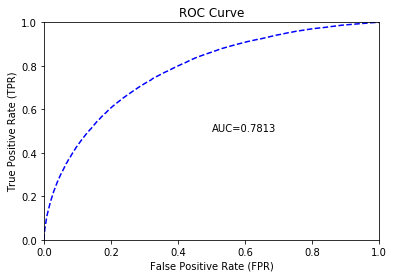

X-Val


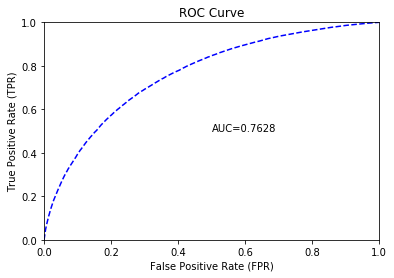

In [37]:
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("X-Val")
gbm_model.model_performance(xval=True).plot()

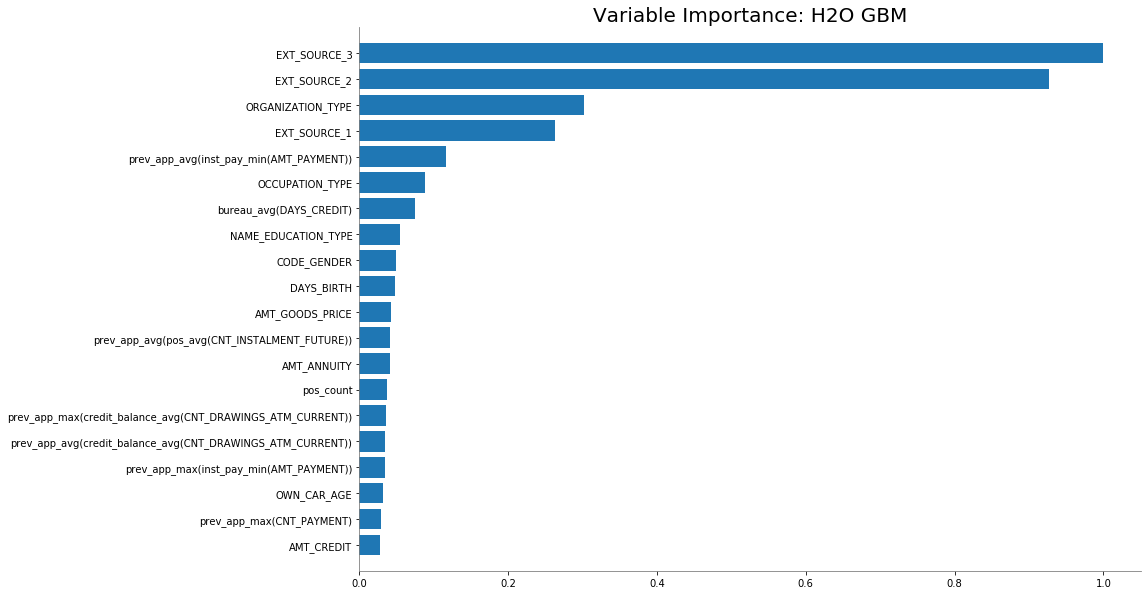

In [27]:
gbm_model.varimp_plot(20)

## Auto ML

In [28]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200417_084801,0.781499,0.244769,0.274235,0.331792,0.259405,0.0672908
StackedEnsemble_BestOfFamily_AutoML_20200417_084801,0.780312,0.245245,0.271549,0.329684,0.259658,0.0674224
XGBoost_3_AutoML_20200417_084801,0.774454,0.241502,0.262289,0.337221,0.258688,0.0669193
GBM_2_AutoML_20200417_084801,0.773784,0.242093,0.260099,0.328162,0.258919,0.0670391
GBM_1_AutoML_20200417_084801,0.773303,0.242656,0.255131,0.343667,0.259274,0.0672231
GLM_1_AutoML_20200417_084801,0.767817,0.244274,0.247271,0.339984,0.259776,0.0674837
XGBoost_1_AutoML_20200417_084801,0.747644,0.254152,0.227684,0.353298,0.264116,0.0697572
XGBoost_2_AutoML_20200417_084801,0.730124,0.265823,0.213109,0.357364,0.267463,0.0715362
DRF_1_AutoML_20200417_084801,0.727893,0.255445,0.201658,0.364662,0.264182,0.0697924


All models

Model Name: StackedEnsemble_AllModels_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.18849483826962604
Accuracy [[0.3227348172019973, 0.9371046889379567]]
AUC 0.9228231892364941
R2 0.30952256506420406
RMSE 0.2263658288961465
Error [[0.3227348172019973, 0.06289531106204327]]
MCC [[0.16904686802988836, 0.5204075912294382]]
Training Data


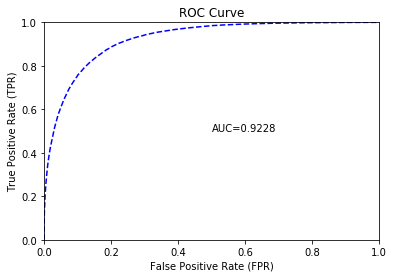

X-Val


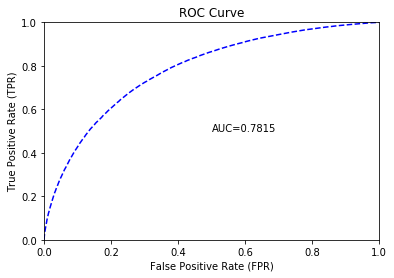

No variable importance
Model Name: StackedEnsemble_BestOfFamily_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.20391183488115835
Accuracy [[0.36331041086710314, 0.9308187349395631]]
AUC 0.8919543926337079
R2 0.24853686570359723
RMSE 0.2361510946926342
Error [[0.36331041086710314, 0.06918126506043687]]
MCC [[0.15503221959946803, 0.4446933341396906]]
Training Data


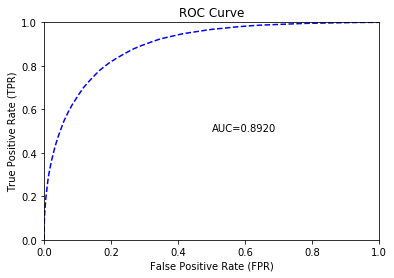

X-Val


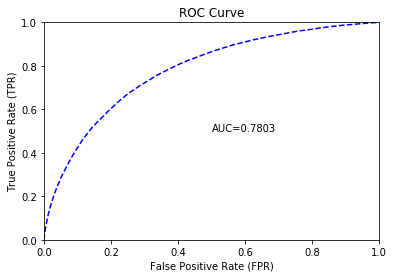

No variable importance
Model Name: XGBoost_3_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.2241063799018271
Accuracy [[0.41938113551291206, 0.9232222587159483]]
AUC 0.8193506049673867
R2 0.15833769494687522
RMSE 0.2499223304656172
Error [[0.41938113551291206, 0.07677774128405168]]
MCC [[0.1913976807129775, 0.3278438086370003]]
Training Data


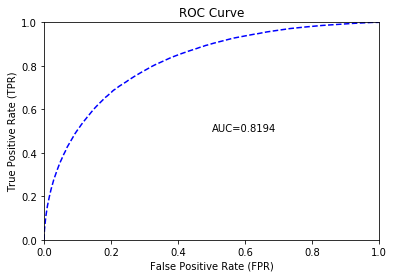

X-Val


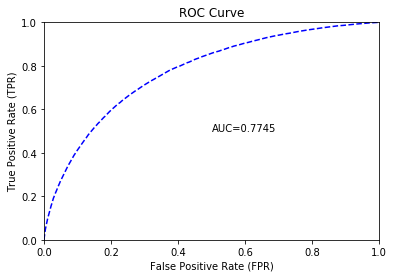

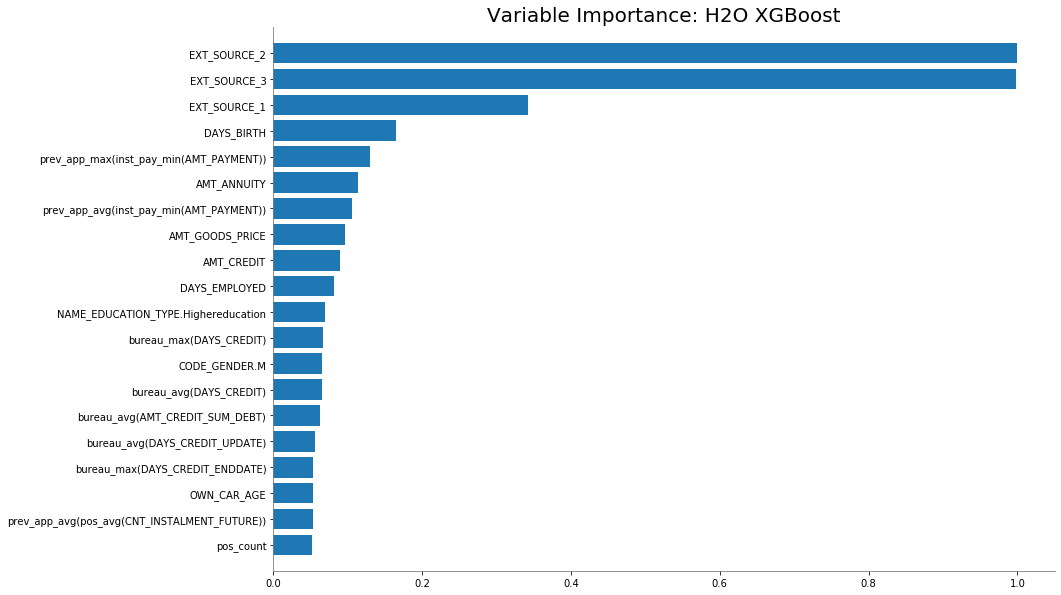

Model Name: GBM_2_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.21108426036770345
Accuracy [[0.3595065568794041, 0.9298073890039706]]
AUC 0.8473861374940589
R2 0.2153147420462822
RMSE 0.24131475097920133
Error [[0.3595065568794041, 0.07019261099602936]]
MCC [[0.2213629884499156, 0.40366921438121667]]
Training Data


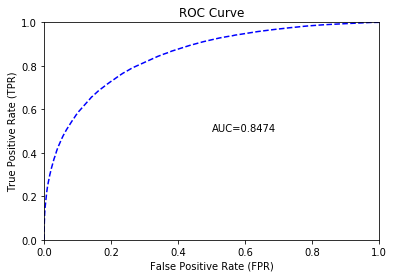

X-Val


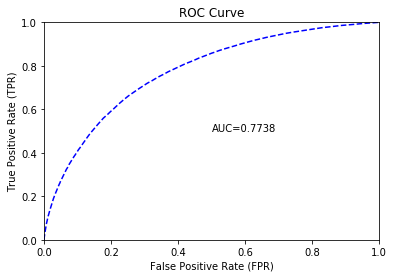

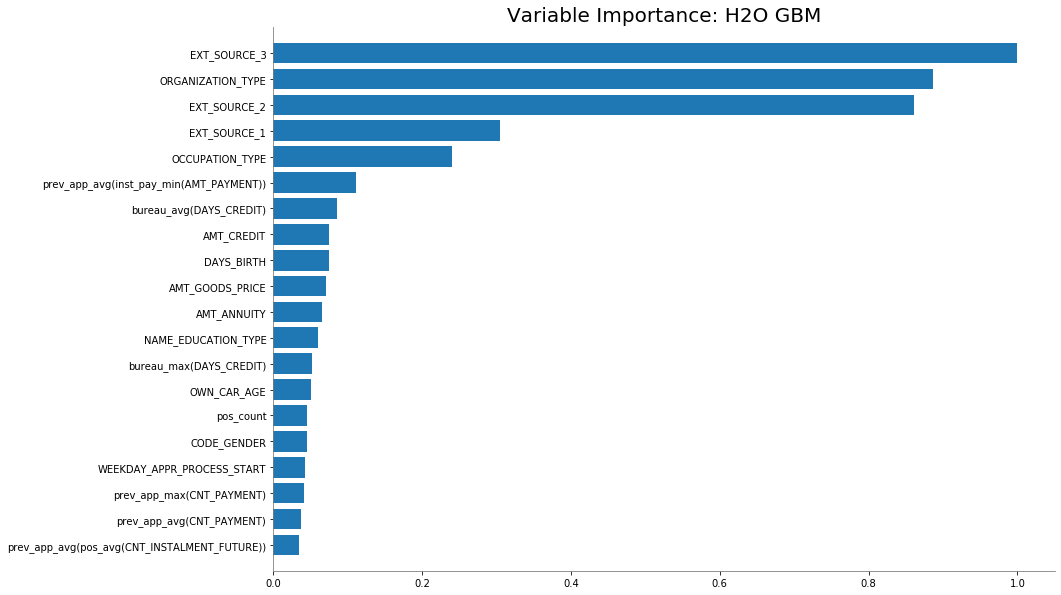

Model Name: GBM_1_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.2216000007348532
Accuracy [[0.3851361333041748, 0.9254465693910137]]
AUC 0.8235529873373607
R2 0.17557644023554486
RMSE 0.24734966154263505
Error [[0.3851361333041748, 0.07455343060898634]]
MCC [[0.21982966599283618, 0.3555956930731301]]
Training Data


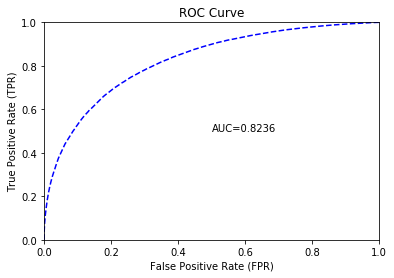

X-Val


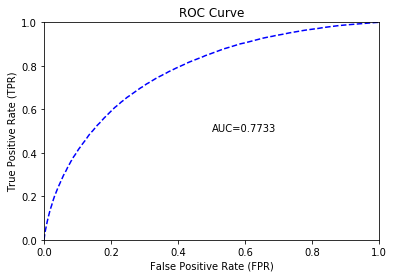

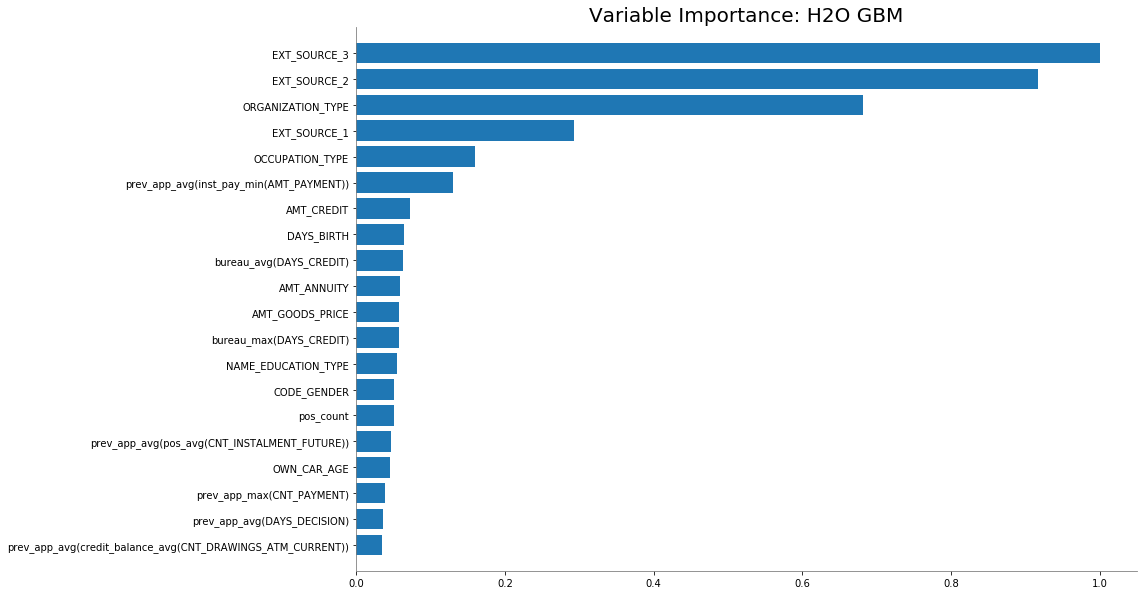

Model Name: GLM_1_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.24229993471066472
Accuracy [[0.5404902961250699, 0.9196679143185121]]
AUC 0.7727333762207267
R2 0.09557675203716265
RMSE 0.259072897268727
Error [[0.5404902961250699, 0.08033208568148786]]
MCC [[0.149738390321855, 0.2578911423151164]]
Training Data


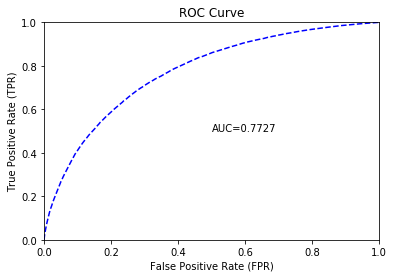

X-Val


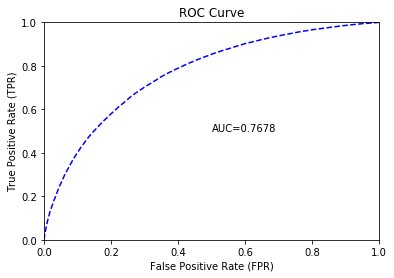

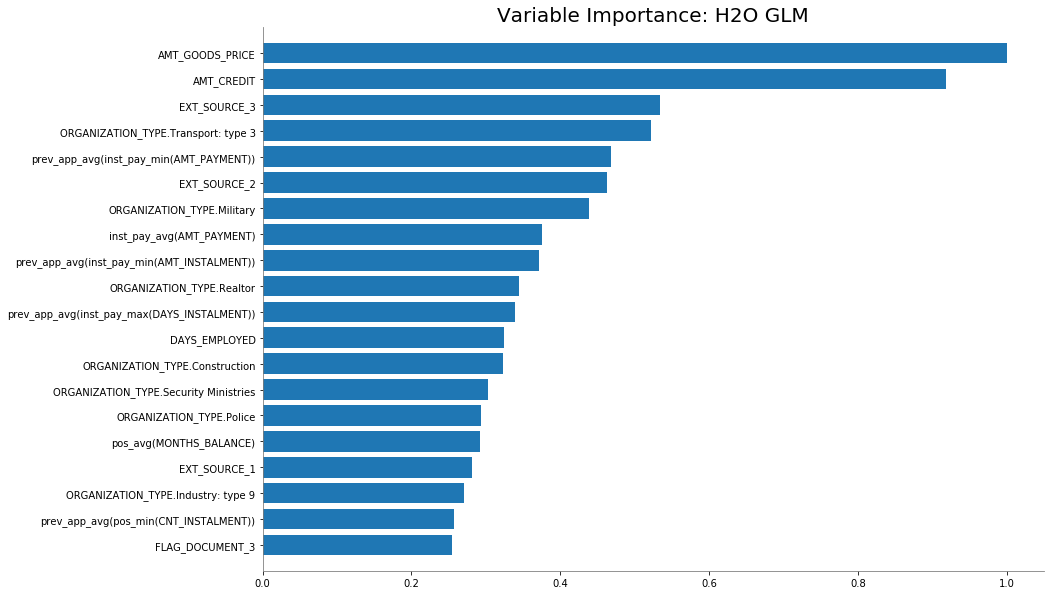

Model Name: XGBoost_1_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.17848768556024797
Accuracy [[0.35704901814460754, 0.9388477160166628]]
AUC 0.9113744432730934
R2 0.3256112409710912
RMSE 0.22371303240850704
Error [[0.35704901814460754, 0.06115228398333716]]
MCC [[0.23969669898985124, 0.5268723336843675]]
Training Data


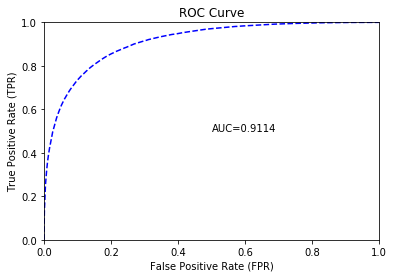

X-Val


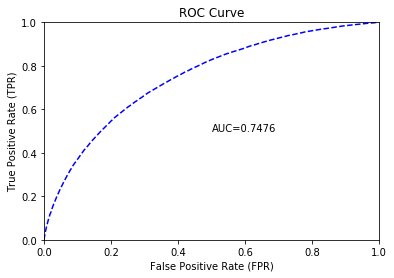

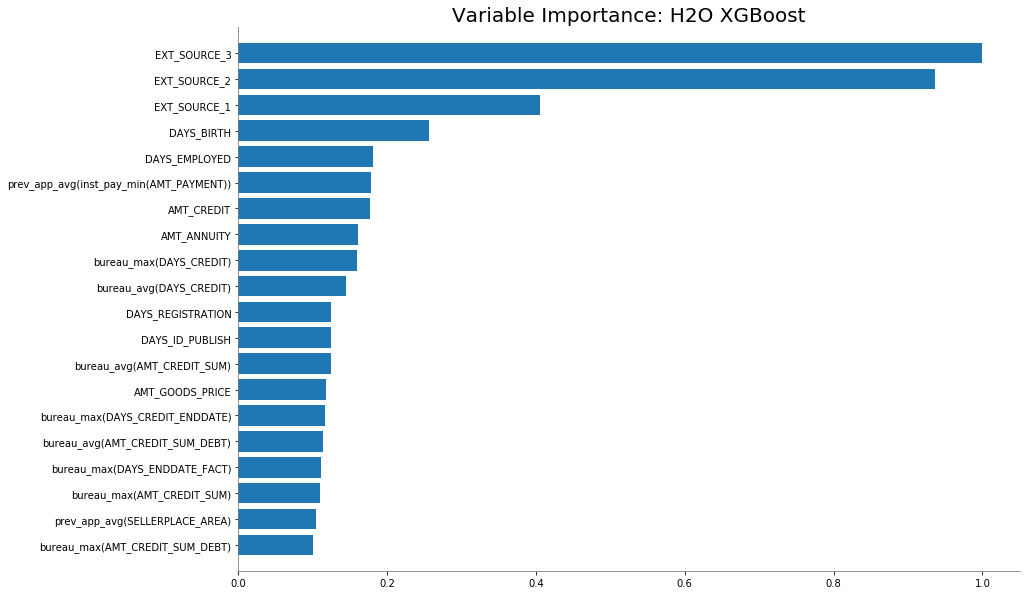

Model Name: XGBoost_2_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.12189234125712944
Accuracy [[0.3053193430105845, 0.9679230986859007]]
AUC 0.9786481250117427
R2 0.5588332776840299
RMSE 0.18094121247764447
Error [[0.3053193430105845, 0.03207690131409935]]
MCC [[0.2827947999749865, 0.7726974319972713]]
Training Data


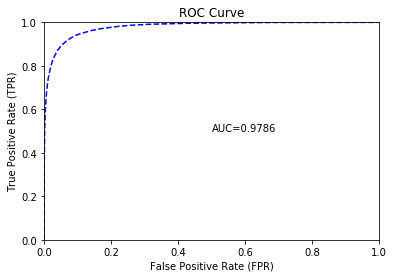

X-Val


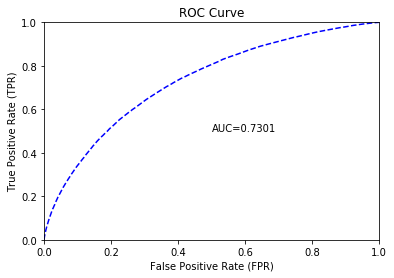

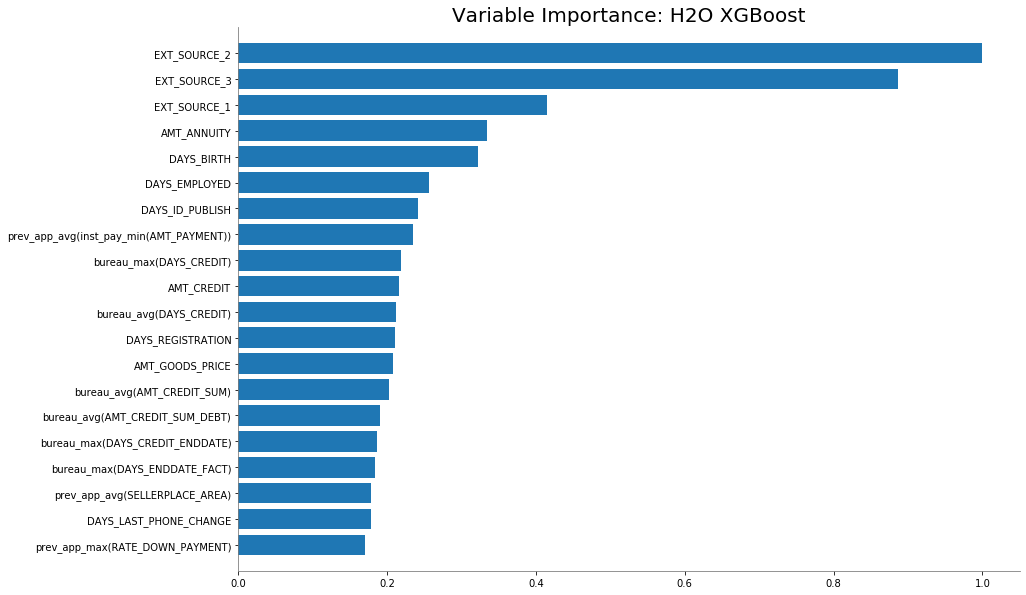

Model Name: DRF_1_AutoML_20200417_084801
Model Type: unsupervised
logloss 0.2598473292880935
Accuracy [[0.6564761135313246, 0.9192874401240931]]
AUC 0.7060356217869412
R2 0.04803782155963876
RMSE 0.26579448801776473
Error [[0.6564761135313246, 0.08071255987590686]]
MCC [[0.12414587320723382, 0.17971679649931444]]
Training Data


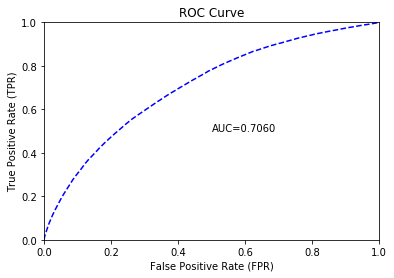

X-Val


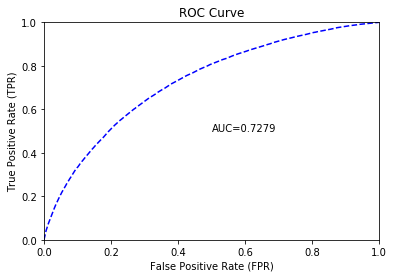

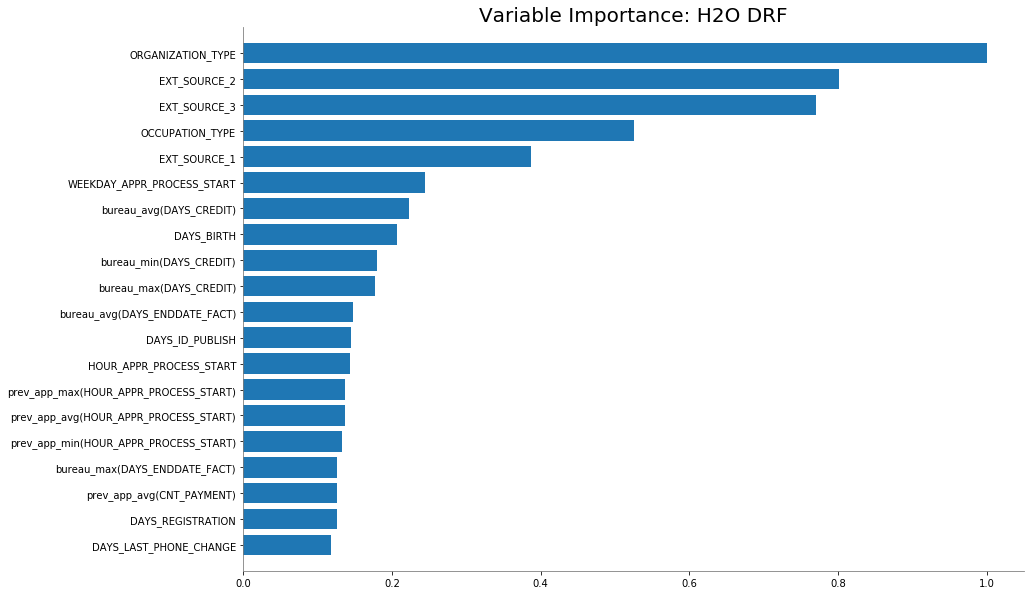

In [31]:
for m in aml.leaderboard.as_data_frame()['model_id']:
    model = h2o.get_model(m)
    print('Model Name:', model.model_id)
    print('Model Type:', model.type)
    print('logloss', model.logloss(valid = False))
    print('Accuracy', model.accuracy(valid = False))
    print('AUC', model.auc(valid = False))
    print('R2', model.r2(valid = False))
    print('RMSE', model.rmse(valid = False))
    print('Error', model.error(valid = False))
    print('MCC', model.mcc(valid = False))
    print("Training Data")
    model.model_performance(train = True).plot()
    print("X-Val")
    model.model_performance(xval=True).plot()
    try:
        model.varimp_plot(20)
    except:
        print('No variable importance')

# Deployment

Use the model for new data.

Auto ML

In [32]:
for m in aml.leaderboard.as_data_frame()['model_id']:
    model = h2o.get_model(m)
    pred = model.predict(df_test)
    pred['SK_ID_CURR'] = df_test['SK_ID_CURR']
    predFrame = pred.as_data_frame()
    predFrame.to_csv('Data/' + model.model_id + '.csv', index=False) 

stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


Gradient Boosting

In [33]:
pred2 = gbm_model.predict(df_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [34]:
pred2['SK_ID_CURR'] = df_test['SK_ID_CURR']
predFrame2 = pred2.as_data_frame()
predFrame2.to_csv('Data/' + gbm_model.model_id + '.csv', index=False)

## Kaggle Result
![CRISP-DM](Data/result.png)

In [35]:
#spark.stop() #closing the spark session

In [36]:
#h2o.cluster().shutdown()